# Analysis - Hashtag

In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse as sps
import pandas as pd


from utils.cuda_cluster import *
from utils.dataset import read_data, factorize_small_cardinality

import core.config as conf


In [2]:
client

Client Scheduler: tcp://127.0.0.1:35501 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 1 Memory: 33.47 GB


## 1. Load data

In [3]:
# data_path = conf.raw_data_path + '*' # for all dataset
data_path = conf.raw_data_path + 'part-00175'
ori_df = read_data(data_path)

number of rows: 3033347


In [4]:
ori_df.columns

Index(['text_ tokens', 'hashtags', 'tweet_id', 'present_media',
       'present_links', 'present_domains', 'tweet_type', 'language',
       'tweet_timestamp', 'engaged_with_user_id',
       'engaged_with_user_follower_count', 'engaged_with_user_following_count',
       'engaged_with_user_is_verified', 'engaged_with_user_account_creation',
       'enaging_user_id', 'enaging_user_follower_count',
       'enaging_user_following_count', 'enaging_user_is_verified',
       'enaging_user_account_creation', 'engagee_follows_engager',
       'reply_timestamp', 'retweet_timestamp',
       'retweet_with_comment_timestamp', 'like_timestamp'],
      dtype='object')

In [49]:
df = ori_df[['engaged_with_user_id', 'engaged_with_user_follower_count', 'engaged_with_user_following_count', 'enaging_user_id', 'enaging_user_follower_count', 'enaging_user_following_count', 'reply_timestamp', 'retweet_timestamp','retweet_with_comment_timestamp', 'like_timestamp']]

In [50]:
df['is_reply'] = df['reply_timestamp'].compute().applymap(lambda x: 1 if x > 0 else 0).astype(np.int32)
df['is_retweet'] = df['retweet_timestamp'].compute().applymap(lambda x: 1 if x > 0 else 0).astype(np.int32)
df['is_comment'] = df['retweet_with_comment_timestamp'].compute().applymap(lambda x: 1 if x > 0 else 0).astype(np.int32)
df['is_like'] = df['like_timestamp'].compute().applymap(lambda x: 1 if x > 0 else 0).astype(np.int32)

df['is_positive'] = df['is_reply'] | df['is_retweet'] | df['is_comment'] | df['is_like']
df['is_negative'] =  df['is_positive'].compute().applymap(lambda x: 1 if x == 0 else 0).astype(np.int32)

df = df.drop('reply_timestamp', axis=1)
df = df.drop('retweet_timestamp', axis=1)
df = df.drop('retweet_with_comment_timestamp', axis=1)
df = df.drop('like_timestamp', axis=1)

In [51]:
total_users = dask_cudf.concat([ori_df["engaged_with_user_id"], ori_df["enaging_user_id"]]).unique().compute()
df, _ = factorize_small_cardinality(df, 'engaged_with_user_id', total_users, True)
df, _ = factorize_small_cardinality(df, 'enaging_user_id', total_users, True)

total_users

0          000000B946F21610D8169031348D6748
1          0000030E0DCCFDF9DBF2DDC031E6DA58
2          0000059852AB4CDFB4C417C550780C7D
3          000005BCF00DCCEABCF7F82BDCFB3543
4          0000079F3828E08D0A604E3E0D78C91F
                         ...               
3511085    FFFFF3D18C31109B40C431CE050BEE2E
3511086    FFFFF50BA9D4FF3225576C8996BE8BAC
3511087    FFFFF7DE6B3CB775180049CB3CD337BA
3511088    FFFFF8D0A1E9C84BD356965A0C74ADB8
3511089    FFFFFA8F28C6657BA57B88D608FA2298
Length: 3511090, dtype: object

In [52]:
df = df.rename(columns={'engaged_with_user_id_encode': 'creator_id'})
df = df.rename(columns={'enaging_user_id_encode': 'engager_id'})
df = df.drop('engaged_with_user_id', axis=1)
df = df.drop('enaging_user_id', axis=1)

df = df.rename(columns={'engaged_with_user_follower_count': 'creator_follower_count'})
df = df.rename(columns={'engaged_with_user_following_count': 'creator_following_count'})
df = df.rename(columns={'enaging_user_follower_count': 'engager_follower_count'})
df = df.rename(columns={'enaging_user_following_count': 'engager_following_count'})

In [53]:
df.head()

,creator_follower_count,creator_following_count,engager_follower_count,engager_following_count,is_reply,is_retweet,is_comment,is_like,is_positive,is_negative,creator_id,engager_id
id,,,,,,,,,,,,
1,4753,1060,76,189,0,0,0,1,1,0,2586120,893844
2,110643,180,260,379,0,0,0,0,0,1,3355961,3173376
3,4480,2953,1259,868,1,0,0,0,1,0,1233947,951213
4,461,157,437,597,0,0,0,1,1,0,3063535,2013995
5,1308,1478,247,404,0,0,0,0,0,1,2280964,3018294


In [10]:
df.compute().describe().astype(np.int64)

,creator_follower_count,creator_following_count,engager_follower_count,engager_following_count,is_reply,is_retweet,is_comment,is_like,is_positive,is_negative,creator_id,engager_id
count,3033347,3033347,3033347,3033347,3033347,3033347,3033347,3033347,3033347,3033347,3033347,3033347
mean,751526,3613,827,706,0,0,0,0,0,0,1760479,1755944
std,4436788,33051,31759,1586,0,0,0,0,0,0,1012183,1013640
min,1,0,0,1,0,0,0,0,0,0,4,0
25%,817,203,70,153,0,0,0,0,0,0,890127,878121
50%,5592,565,210,334,0,0,0,0,0,1,1761731,1756012
75%,88088,1471,577,735,0,0,0,1,1,1,2637234,2634005
max,129240509,4256371,51817106,402187,1,1,1,1,1,1,3511089,3511088


## 2. creator - follower count

In [54]:
creator_follower_count = df.compute().groupby('creator_id')[['creator_follower_count']].nth(-1)
creator_follower_count = creator_follower_count.reset_index()
creator_follower_count.head()

,creator_id,creator_follower_count
0,4,2089
1,10,11226
2,14,9198
3,15,99
4,17,12404


In [55]:
creator_engagements = df.groupby('creator_id')[['is_reply',	'is_retweet',	'is_comment',	'is_like',	'is_positive',	'is_negative']].sum().compute()
creator_engagements = creator_engagements.reset_index()
creator_engagements.head()

,creator_id,is_reply,is_retweet,is_comment,is_like,is_positive,is_negative
0,1553202,0,0,0,0,0,1
1,3058672,0,0,0,0,0,1
2,343354,0,0,0,0,0,2
3,2745912,0,1,0,0,1,0
4,1124902,0,0,0,1,1,0


In [56]:
len(creator_engagements), len(creator_follower_count)

(1558866, 1558866)

In [67]:
follow_count_df = creator_follower_count.merge(creator_engagements, on=['creator_id'], how='left')
len(follow_count_df)

1558866

In [59]:
sorted_creator_follower = follow_count_df.sort_values('creator_follower_count', ascending=False)

top_n = 10000
top_n_creator = sorted_creator_follower[:top_n]
top_n_creator.describe().astype(np.int64)

,creator_id,creator_follower_count,is_reply,is_retweet,is_comment,is_like,is_positive,is_negative
count,10000,10000,10000,10000,10000,10000,10000,10000
mean,1757863,2576096,0,2,0,11,14,19
std,1006794,5119106,1,8,0,43,49,41
min,355,660258,0,0,0,0,0,0
25%,894605,886058,0,0,0,0,0,2
50%,1762141,1297953,0,0,0,2,2,7
75%,2623967,2370300,0,1,0,7,9,19
max,3511046,129240509,45,228,33,1324,1529,1080


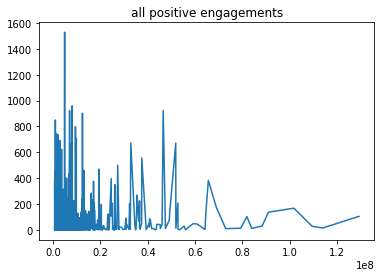

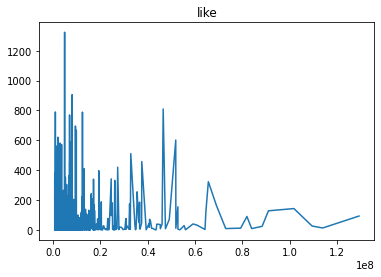

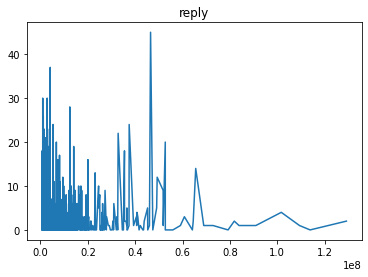

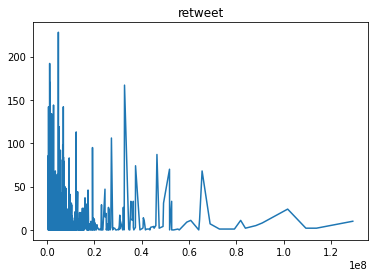

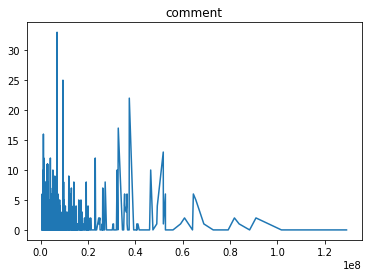

In [60]:
plt.title('all positive engagements')
plt.plot(top_n_creator['creator_follower_count'].to_array(), top_n_creator['is_positive'].to_array())
plt.show()

plt.title('like')
plt.plot(top_n_creator['creator_follower_count'].to_array(), top_n_creator['is_like'].to_array())
plt.show()

plt.title('reply')
plt.plot(top_n_creator['creator_follower_count'].to_array(), top_n_creator['is_reply'].to_array())
plt.show()

plt.title('retweet')
plt.plot(top_n_creator['creator_follower_count'].to_array(), top_n_creator['is_retweet'].to_array())
plt.show()

plt.title('comment')
plt.plot(top_n_creator['creator_follower_count'].to_array(), top_n_creator['is_comment'].to_array())
plt.show()

## 3. creator - following count

In [68]:
creator_following_count = df.compute().groupby('creator_id')[['creator_following_count']].nth(-1)
creator_following_count = creator_following_count.reset_index()
creator_following_count.head()

follow_count_df = follow_count_df.merge(creator_following_count, on=['creator_id'], how='left')
len(follow_count_df)

1558866

In [69]:
follow_count_df.head()

,creator_id,creator_follower_count,is_reply,is_retweet,is_comment,is_like,is_positive,is_negative,creator_following_count
0,50079,1781,1,0,0,0,1,0,1938
1,50086,4851,1,0,0,0,1,1,206
2,50083,599,0,0,0,0,0,1,567
3,50089,550,0,0,0,1,1,0,516
4,50113,4326,0,0,0,0,0,1,3674


In [70]:
sorted_creator_following = follow_count_df.sort_values('creator_following_count', ascending=False)

top_n = 10000
top_n_creator = sorted_creator_following[:top_n]
top_n_creator.describe().astype(np.int64)

,creator_id,creator_follower_count,is_reply,is_retweet,is_comment,is_like,is_positive,is_negative,creator_following_count
count,10000,10000,10000,10000,10000,10000,10000,10000,10000
mean,1746004,237577,0,0,0,1,2,3,80860
std,1013877,2385634,0,2,0,10,12,9,130952
min,32,17259,0,0,0,0,0,0,26199
25%,881858,40546,0,0,0,0,0,1,32604
50%,1737657,65950,0,0,0,0,0,1,45146
75%,2621197,131317,0,0,0,1,1,3,76978
max,3510922,129240509,74,198,21,437,637,488,4256371


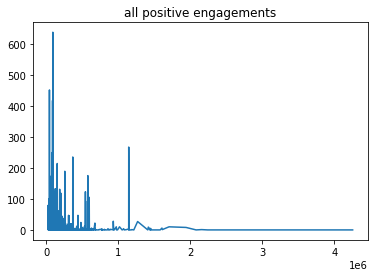

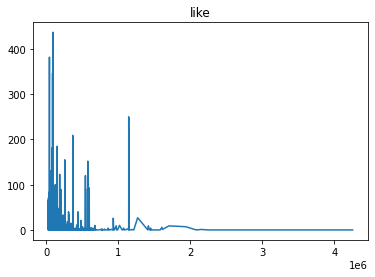

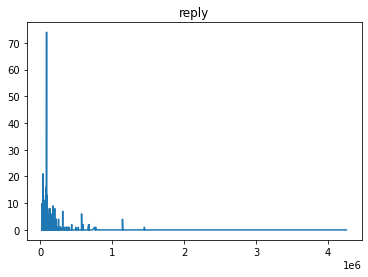

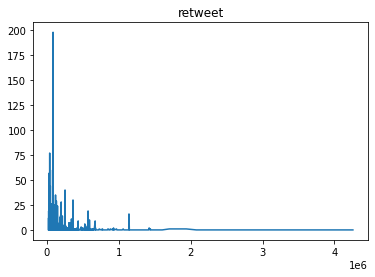

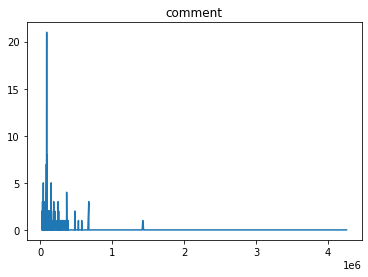

In [72]:
plt.title('all positive engagements')
plt.plot(top_n_creator['creator_following_count'].to_array(), top_n_creator['is_positive'].to_array())
plt.show()

plt.title('like')
plt.plot(top_n_creator['creator_following_count'].to_array(), top_n_creator['is_like'].to_array())
plt.show()

plt.title('reply')
plt.plot(top_n_creator['creator_following_count'].to_array(), top_n_creator['is_reply'].to_array())
plt.show()

plt.title('retweet')
plt.plot(top_n_creator['creator_following_count'].to_array(), top_n_creator['is_retweet'].to_array())
plt.show()

plt.title('comment')
plt.plot(top_n_creator['creator_following_count'].to_array(), top_n_creator['is_comment'].to_array())
plt.show()

## 4. engager - follower count

In [74]:
engager_follower_count = df.compute().groupby('creator_id')[['engager_follower_count']].nth(-1)
engager_follower_count = engager_follower_count.reset_index()
engager_follower_count.head()

follow_count_df = follow_count_df.merge(engager_follower_count, on=['creator_id'], how='left')
len(follow_count_df)

1558866

In [79]:
sorted_engager_follower = follow_count_df.sort_values('engager_follower_count', ascending=False)

top_n = 10000
top_n_engager = sorted_engager_follower[:top_n]
top_n_engager.describe().astype(np.int64)

,creator_id,creator_follower_count,is_reply,is_retweet,is_comment,is_like,is_positive,is_negative,creator_following_count,engager_following_count,engager_follower_count
count,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
mean,1755166,26167,0,0,0,0,0,0,4216,9227,40657
std,1019096,279993,0,0,0,3,3,3,16190,15398,132481
min,765,6,0,0,0,0,0,0,0,3,13111
25%,868781,1212,0,0,0,0,0,0,514,946,15693
50%,1757570,3601,0,0,0,0,0,1,1256,3824,20609
75%,2642825,11586,0,0,0,1,1,1,3539,13814,32705
max,3510747,16839400,17,39,5,234,284,317,516800,402187,5211678


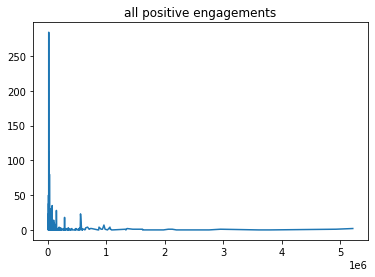

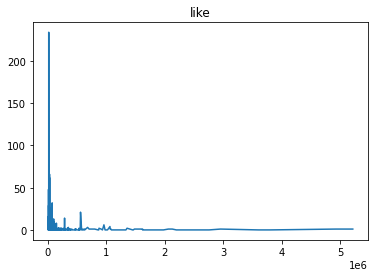

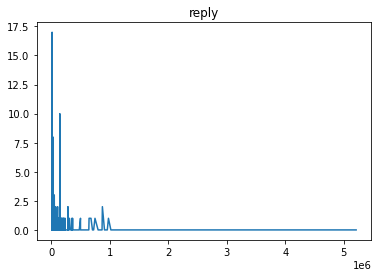

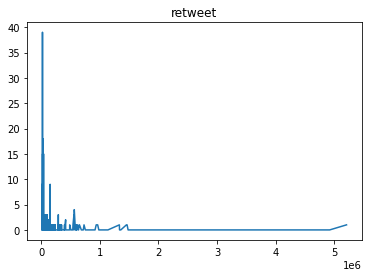

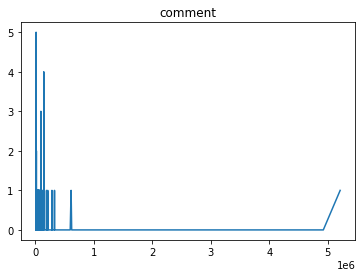

In [80]:
plt.title('all positive engagements')
plt.plot(top_n_engager['engager_follower_count'].to_array(), top_n_engager['is_positive'].to_array())
plt.show()

plt.title('like')
plt.plot(top_n_engager['engager_follower_count'].to_array(), top_n_engager['is_like'].to_array())
plt.show()

plt.title('reply')
plt.plot(top_n_engager['engager_follower_count'].to_array(), top_n_engager['is_reply'].to_array())
plt.show()

plt.title('retweet')
plt.plot(top_n_engager['engager_follower_count'].to_array(), top_n_engager['is_retweet'].to_array())
plt.show()

plt.title('comment')
plt.plot(top_n_engager['engager_follower_count'].to_array(), top_n_engager['is_comment'].to_array())
plt.show()

## 5. engager - following count

In [86]:
engager_following_count = df.compute().groupby('creator_id')[['engager_following_count']].nth(-1)
engager_following_count = engager_following_count.reset_index()
engager_following_count.head()

follow_count_df = follow_count_df.merge(engager_following_count, on=['creator_id'], how='left')
len(follow_count_df)

1558866

In [87]:
sorted_engager_following = follow_count_df.sort_values('engager_following_count', ascending=False)

top_n = 10000
top_n_engager = sorted_engager_following[:top_n]
top_n_engager.describe().astype(np.int64)

,creator_id,creator_follower_count,is_reply,is_retweet,is_comment,is_like,is_positive,is_negative,creator_following_count,engager_follower_count,engager_following_count
count,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
mean,1757529,13898,0,0,0,0,0,0,6803,17946,13413
std,1019029,178752,0,0,0,2,3,2,23121,31168,13684
min,10,9,0,0,0,0,0,0,0,1780,6892
25%,870310,1174,0,0,0,0,0,0,1023,8911,8080
50%,1757872,3144,0,0,0,0,0,1,2773,11728,9974
75%,2642611,8264,0,0,0,1,1,1,5643,17754,13883
max,3510747,16517617,3,30,4,209,235,255,1072339,1334647,402187


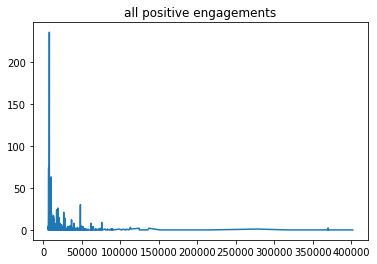

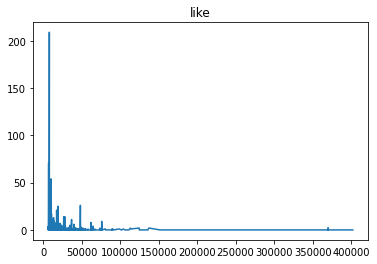

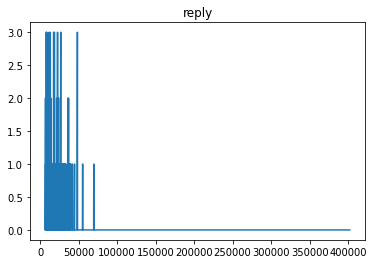

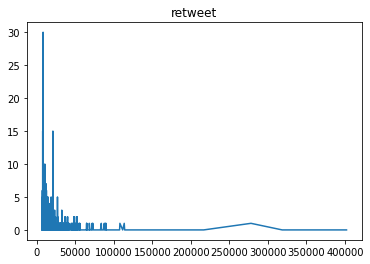

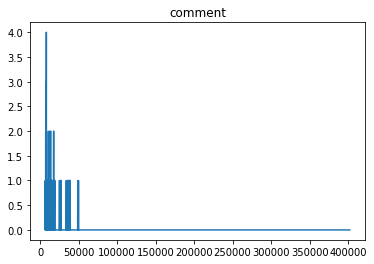

In [89]:
plt.title('all positive engagements')
plt.plot(top_n_engager['engager_following_count'].to_array(), top_n_engager['is_positive'].to_array())
plt.show()

plt.title('like')
plt.plot(top_n_engager['engager_following_count'].to_array(), top_n_engager['is_like'].to_array())
plt.show()

plt.title('reply')
plt.plot(top_n_engager['engager_following_count'].to_array(), top_n_engager['is_reply'].to_array())
plt.show()

plt.title('retweet')
plt.plot(top_n_engager['engager_following_count'].to_array(), top_n_engager['is_retweet'].to_array())
plt.show()

plt.title('comment')
plt.plot(top_n_engager['engager_following_count'].to_array(), top_n_engager['is_comment'].to_array())
plt.show()

## 6. The (creator/engager)'s (follower/following) count of popular tweets